In [51]:
import os
import pandas as pd
import torch
import torch.nn as nn
import numpy as np
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from torch.utils.checkpoint import checkpoint
from sklearn.feature_extraction.text import CountVectorizer



class ComplexCNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(ComplexCNN, self).__init__()

        self.layer1 = nn.Sequential(
            nn.Conv1d(1, hidden_size, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm1d(hidden_size),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2, stride=2)
        )
        self.layer2 = nn.Sequential(
            nn.Conv1d(hidden_size, hidden_size * 2, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm1d(hidden_size * 2),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2, stride=2)
        )
        self.layer3 = nn.Sequential(
            nn.Conv1d(hidden_size * 2, hidden_size * 4, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm1d(hidden_size * 4),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2, stride=2)
        )
        self.layer4 = nn.Sequential(
            nn.Conv1d(hidden_size * 4, hidden_size * 8, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm1d(hidden_size * 8),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2, stride=2)
        )
        self.layer5 = nn.Sequential(
            nn.Conv1d(hidden_size * 8, hidden_size * 16, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm1d(hidden_size * 16),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2, stride=2)
        )
        # Calculate the size of the input to the first fully connected layer
        fc_input_size = hidden_size * 16 * (input_size // (2 ** 5))  # 2^5 because of 5 maxpooling layers

        self.fc1 = nn.Linear(fc_input_size, hidden_size * 8)
        self.dropout = nn.Dropout(p=0.5)  # Adding dropout layer
        self.fc2 = nn.Linear(hidden_size * 8, num_classes)

    def forward(self, x):
        out = checkpoint(self.layer1, x)
        out = checkpoint(self.layer2, out)
        out = checkpoint(self.layer3, out)
        out = checkpoint(self.layer4, out)
        out = checkpoint(self.layer5, out)

        out = out.view(out.size(0), -1)  # Flattening for the fully connected layer

        out = self.fc1(out)
        out = self.dropout(out)  # Applying dropout
        out = self.fc2(out)

        return out


In [52]:
import os
import pandas as pd

##########
# step 1 #
##########
# Load the CSV file and create lineage dictionaries (you can use your previous code)
csv_path = r'D:\jupyterNotebook\ComArc\dataset.csv'
data = pd.read_csv(csv_path)

lineage_to_number = {}
lineage_count = 0

id_to_lineage_number = {}

for index, row in data.iterrows():
    lineage = row['lineage']
    if lineage not in lineage_to_number:
        lineage_to_number[lineage] = lineage_count
        lineage_count += 1

    lineage_number = lineage_to_number[lineage]

    # Remove extra double quotes from the ID before storing it
    id_cleaned = row['id'].strip('"')
    id_to_lineage_number[id_cleaned] = lineage_number

# Create a list to store DataFrame rows
data_rows = []

##########
# step 3 #
##########
# Iterate through the files in the "fasta_files" folder
data_rows=[]
fasta_folder_path = r'D:\jupyterNotebook\ComArc\modified_fasta_files'
for filename in os.listdir(fasta_folder_path):
    if filename.endswith(".fasta"):
        file_path = os.path.join(fasta_folder_path, filename)

        # Read the content of the FASTA file
        with open(file_path, 'r') as fasta_file:
            fasta_content = fasta_file.read()

        # Get the corresponding lineage number based on the filename
        id_from_filename = os.path.splitext(filename)[0]

        # Remove extra double quotes and underscores from the ID before using it
        id_cleaned = id_from_filename.strip('"_')

        if id_cleaned in id_to_lineage_number:
            lineage_number = id_to_lineage_number[id_cleaned]
        else:
            lineage_number = -1  # Set to -1 if ID is not found

        # Append a row to the data_rows list
        data_rows.append({'fasta_content': fasta_content, 'lineage_number': lineage_number})

# Create the DataFrame
fasta_df = pd.DataFrame(data_rows)

# Print the DataFrame
print(fasta_df)

# function to convert sequence strings into k-mer words, default size = 6 (hexamer words)
def getKmers(sequence, size=6):
    return [sequence[x:x+size].lower() for x in range(len(sequence) - size + 1)]

fasta_df['words'] = fasta_df.apply(lambda x: getKmers(x['fasta_content']), axis=1)
fasta_df = fasta_df.drop('fasta_content', axis=1)

fasta_texts = list(fasta_df['words'])
for item in range(len(fasta_texts)):
    fasta_texts[item] = ' '.join(fasta_texts[item])
y_data = fasta_df.iloc[:, 0].values





                                          fasta_content  lineage_number
0     TAACAAACCAACCAACTTTCGATCTCTTGTAGATCTGTTCTCTAAA...              20
1     AACCAACCAACTTTCGATCTCTTGTAGATCTGTTCTCTAAACGAAC...              20
2     ACTTTCGATCTCTTGTAGATCTGTTCTCTAAACGAACTTTAAAATC...              20
3     AAGGTTTATACCTTCCCAGGTAACAAACCAACCAACTTTCGATCTC...              20
4     TACCTTCCCAGGTAACAAACCAACCAACTTTCGATCTCTTGTAGAT...              20
...                                                 ...             ...
4995  NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN...              59
4996  NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN...              59
4997  NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN...              34
4998  NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN...               2
4999  NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN...               2

[5000 rows x 2 columns]


In [53]:
# Creating the Bag of Words model using CountVectorizer()
# This is equivalent to k-mer counting
# The n-gram size of 4 was previously determined by testing
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer()
X = cv.fit_transform(fasta_texts)

In [4]:
print("start training")
X_train, X_test, y_train, y_test = train_test_split(X, y_data, test_size=0.2, random_state=42)

# Initialize the ComplexCNN model
input_size = X_train.shape[1]
hidden_size = 64
unique_labels = np.unique(y_data)
numClasses = len(unique_labels)
num_classes = numClasses
model = ComplexCNN(input_size, hidden_size, num_classes)

# Move the model to the appropriate device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.00001)

# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train.toarray(), dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train, dtype=torch.long).to(device)
X_test_tensor = torch.tensor(X_test.toarray(), dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test, dtype=torch.long).to(device)

small_batch_size = 64

# Create PyTorch DataLoader for train and test sets
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
train_loader = DataLoader(train_dataset, batch_size=small_batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=small_batch_size, shuffle=False)

train_loader_size = len(train_loader)
print("train_loader_size:", train_loader_size)

num_epochs = 100
for epoch in range(num_epochs):
    print("epoch:", epoch)
    model.train()
    epoch_loss = 0  # Initialize loss for the epoch
    correct_predictions = 0  # Initialize correct predictions for accuracy calculation

    for i, (batch_X, batch_y) in enumerate(train_loader):
        if i % 10 == 0:
            print("batch:", i, "out of", train_loader_size)
        optimizer.zero_grad()
        outputs = model(batch_X.unsqueeze(1))  # Add a channel dimension
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()  # Accumulate loss
        _, predicted = torch.max(outputs, 1)
        correct_predictions += (predicted == batch_y).sum().item()  # Count correct predictions

    # Calculate and print accuracy and loss for the epoch
    accuracy = correct_predictions / len(train_dataset)
    avg_loss = epoch_loss / len(train_loader)
    print("Epoch [{}/{}], Loss: {:.4f}, Accuracy: {:.4f}".format(epoch + 1, num_epochs, avg_loss, accuracy))
# Evaluation
model.eval()
y_pred = []
with torch.no_grad():
    for batch_X, _ in test_loader:
        outputs = model(batch_X.unsqueeze(1))  # Add a channel dimension
        _, predicted = torch.max(outputs, 1)
        y_pred.extend(predicted.cpu().numpy())

# Calculate and print metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

print("Accuracy: {:.4f}".format(accuracy))
print("Precision: {:.4f}".format(precision))
print("Recall: {:.4f}".format(recall))
print("F1 Score: {:.4f}".format(f1))

start training
train_loader_size: 63
epoch: 0
batch: 0 out of 63


D:\condaEnvs\Lib\site-packages\torch\utils\checkpoint.py:31: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


batch: 10 out of 63
batch: 20 out of 63
batch: 30 out of 63
batch: 40 out of 63
batch: 50 out of 63
batch: 60 out of 63
Epoch [1/100], Loss: 5.5984, Accuracy: 0.0180
epoch: 1
batch: 0 out of 63
batch: 10 out of 63
batch: 20 out of 63
batch: 30 out of 63
batch: 40 out of 63
batch: 50 out of 63
batch: 60 out of 63
Epoch [2/100], Loss: 5.1133, Accuracy: 0.0270
epoch: 2
batch: 0 out of 63
batch: 10 out of 63
batch: 20 out of 63
batch: 30 out of 63
batch: 40 out of 63
batch: 50 out of 63
batch: 60 out of 63
Epoch [3/100], Loss: 4.9958, Accuracy: 0.0420
epoch: 3
batch: 0 out of 63
batch: 10 out of 63
batch: 20 out of 63
batch: 30 out of 63
batch: 40 out of 63
batch: 50 out of 63
batch: 60 out of 63
Epoch [4/100], Loss: 4.5595, Accuracy: 0.0668
epoch: 4
batch: 0 out of 63
batch: 10 out of 63
batch: 20 out of 63
batch: 30 out of 63
batch: 40 out of 63
batch: 50 out of 63
batch: 60 out of 63
Epoch [5/100], Loss: 4.3734, Accuracy: 0.0958
epoch: 5
batch: 0 out of 63
batch: 10 out of 63
batch: 20 

batch: 10 out of 63
batch: 20 out of 63
batch: 30 out of 63
batch: 40 out of 63
batch: 50 out of 63
batch: 60 out of 63
Epoch [43/100], Loss: 1.2774, Accuracy: 0.7100
epoch: 43
batch: 0 out of 63
batch: 10 out of 63
batch: 20 out of 63
batch: 30 out of 63
batch: 40 out of 63
batch: 50 out of 63
batch: 60 out of 63
Epoch [44/100], Loss: 1.2570, Accuracy: 0.7180
epoch: 44
batch: 0 out of 63
batch: 10 out of 63
batch: 20 out of 63
batch: 30 out of 63
batch: 40 out of 63
batch: 50 out of 63
batch: 60 out of 63
Epoch [45/100], Loss: 1.2465, Accuracy: 0.7073
epoch: 45
batch: 0 out of 63
batch: 10 out of 63
batch: 20 out of 63
batch: 30 out of 63
batch: 40 out of 63
batch: 50 out of 63
batch: 60 out of 63
Epoch [46/100], Loss: 1.1921, Accuracy: 0.7270
epoch: 46
batch: 0 out of 63
batch: 10 out of 63
batch: 20 out of 63
batch: 30 out of 63
batch: 40 out of 63
batch: 50 out of 63
batch: 60 out of 63
Epoch [47/100], Loss: 1.1702, Accuracy: 0.7302
epoch: 47
batch: 0 out of 63
batch: 10 out of 63


batch: 10 out of 63
batch: 20 out of 63
batch: 30 out of 63
batch: 40 out of 63
batch: 50 out of 63
batch: 60 out of 63
Epoch [85/100], Loss: 0.5448, Accuracy: 0.8815
epoch: 85
batch: 0 out of 63
batch: 10 out of 63
batch: 20 out of 63
batch: 30 out of 63
batch: 40 out of 63
batch: 50 out of 63
batch: 60 out of 63
Epoch [86/100], Loss: 0.6162, Accuracy: 0.8665
epoch: 86
batch: 0 out of 63
batch: 10 out of 63
batch: 20 out of 63
batch: 30 out of 63
batch: 40 out of 63
batch: 50 out of 63
batch: 60 out of 63
Epoch [87/100], Loss: 0.5031, Accuracy: 0.9070
epoch: 87
batch: 0 out of 63
batch: 10 out of 63
batch: 20 out of 63
batch: 30 out of 63
batch: 40 out of 63
batch: 50 out of 63
batch: 60 out of 63
Epoch [88/100], Loss: 0.5354, Accuracy: 0.8848
epoch: 88
batch: 0 out of 63
batch: 10 out of 63
batch: 20 out of 63
batch: 30 out of 63
batch: 40 out of 63
batch: 50 out of 63
batch: 60 out of 63
Epoch [89/100], Loss: 0.6232, Accuracy: 0.8598
epoch: 89
batch: 0 out of 63
batch: 10 out of 63


In [57]:

X_train, X_test, y_train, y_test = train_test_split(X, y_data, test_size=0.2, random_state=42)

# Initialize the ComplexCNN model
input_size = X_train.shape[1]
hidden_size = 64
unique_labels = np.unique(y_data)
numClasses = len(unique_labels)
num_classes = numClasses
model = ComplexCNN(input_size, hidden_size, num_classes)

# Move the model to the appropriate device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.00001)

# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train.toarray(), dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train, dtype=torch.long).to(device)
X_test_tensor = torch.tensor(X_test.toarray(), dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test, dtype=torch.long).to(device)

small_batch_size = 64

# Create PyTorch DataLoader for train and test sets
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
train_loader = DataLoader(train_dataset, batch_size=small_batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=small_batch_size, shuffle=False)

train_loader_size = len(train_loader)
print("train_loader_size:", train_loader_size)

train_loader_size: 63


In [6]:
# Save the model to the current working directory
torch.save(model.state_dict(), 'model.pth')


In [61]:
model.load_state_dict(torch.load('model.pth'))
model.eval()

y_pred = []
with torch.no_grad():
    for batch_X, _ in test_loader:
        outputs = model(batch_X.unsqueeze(1))  # Add a channel dimension
        _, predicted = torch.max(outputs, 1)
        y_pred.extend(predicted.cpu().numpy())

# Calculate and print metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

print("Accuracy: {:.4f}".format(accuracy))
print("Precision: {:.4f}".format(precision))
print("Recall: {:.4f}".format(recall))
print("F1 Score: {:.4f}".format(f1))

D:\condaEnvs\Lib\site-packages\torch\utils\checkpoint.py:31: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


Accuracy: 0.8990
Precision: 0.9325
Recall: 0.8990
F1 Score: 0.8990


In [62]:
number_to_lineage = {v: k for k, v in lineage_to_number.items()}

# Iterate through numeric identifiers from 1 to 100
# for numeric_identifier in range(0, 100):
#     if numeric_identifier in number_to_lineage:
#         lineage_name = number_to_lineage[numeric_identifier]
#         print(f"Numeric Identifier: {numeric_identifier} corresponds to Lineage: {lineage_name}")
#     else:
#         print(f"Numeric Identifier: {numeric_identifier} not found in mapping.")

In [69]:
import pickle
# Your dictionary
my_dict = {
    'key1': 'value1',
    'key2': 'value2',
    'key3': 'value3'
}

# Specify the file path where you want to save the dictionary
file_path = 'number_to_lineage.pkl'  # Change this to the desired file path

# Save the dictionary to a file
with open(file_path, 'wb') as file:
    pickle.dump(number_to_lineage, file)

print("Dictionary saved to", file_path)

Dictionary saved to number_to_lineage.pkl


In [63]:
from tqdm import tqdm
from sklearn.metrics import precision_score

def evaluate(model, test_loader, class_to_lineage):
    lineage_to_class = {v: k for k, v in class_to_lineage.items()}

    model.eval()
    lineage_metrics = {lineage: {'total': 0, 'correct': 0, 'top3_correct': 0, 'top5_correct': 0} for lineage in
                       class_to_lineage.values()}

    all_predictions = []
    all_labels = []

    with torch.no_grad():
        for sequences, labels in tqdm(test_loader, desc="Evaluating"):
            sequences, labels = sequences.float(), labels
            sequences = sequences.unsqueeze(1)  # Add an extra channel dimension
            outputs = model(sequences).squeeze(1)  # squeeze the 2nd dimension

            _, predicted = torch.max(outputs, 1)
            _, top3_pred = torch.topk(outputs, 3)
            _, top5_pred = torch.topk(outputs, 5)

            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

            for i in range(len(labels)):
                lineage_name = class_to_lineage[labels[i].item()]
                lineage_metrics[lineage_name]['total'] += 1
                lineage_metrics[lineage_name]['correct'] += (predicted[i] == labels[i])
                lineage_metrics[lineage_name]['top3_correct'] += (labels[i] in top3_pred[i])
                lineage_metrics[lineage_name]['top5_correct'] += (labels[i] in top5_pred[i])

    metrics_data = []
    for lineage, metrics in lineage_metrics.items():
        if metrics['total'] > 0:
            accuracy = metrics['correct'] / metrics['total']
            precision = precision_score(all_labels, all_predictions, labels=[lineage_to_class[lineage]], average='micro')
            top3acc = metrics['top3_correct'] / metrics['total']
            top5acc = metrics['top5_correct'] / metrics['total']
            metrics_data.append([lineage, accuracy, precision, top3acc, top5acc])

    results_df = pd.DataFrame(metrics_data, columns=['Lineage', 'accuracy', 'precision', 'top3acc', 'top5acc'])
    results_df.to_csv("results.csv", index=False)

In [66]:
evaluate(model,test_loader, number_to_lineage)

Evaluating:   0%|                                                                               | 0/16 [00:00<?, ?it/s]D:\condaEnvs\Lib\site-packages\torch\utils\checkpoint.py:31: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
Evaluating: 100%|██████████████████████████████████████████████████████████████████████| 16/16 [00:09<00:00,  1.70it/s]


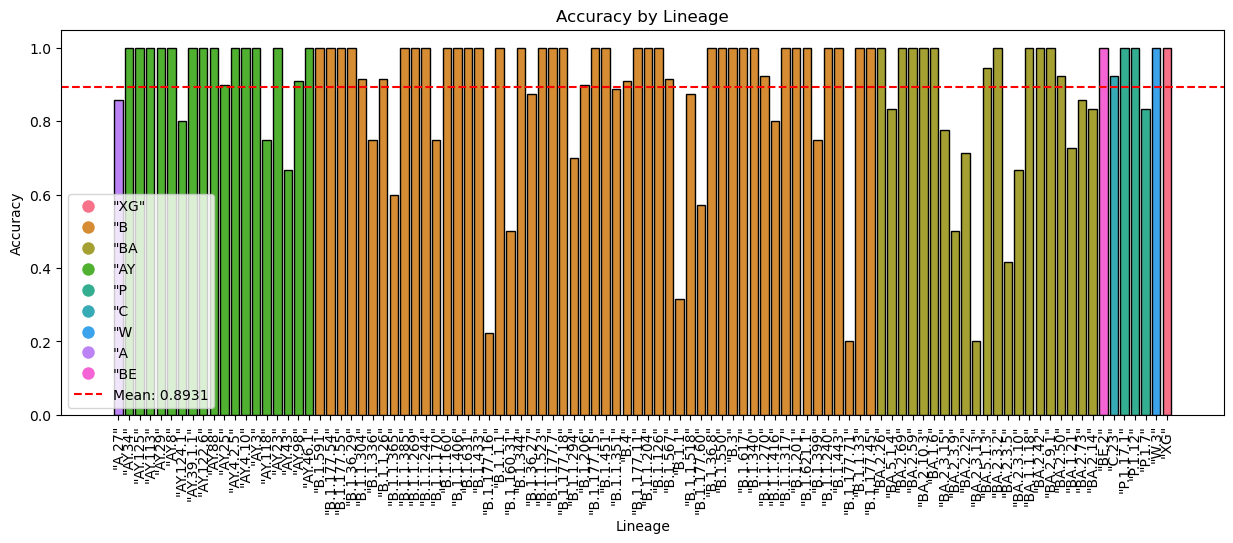

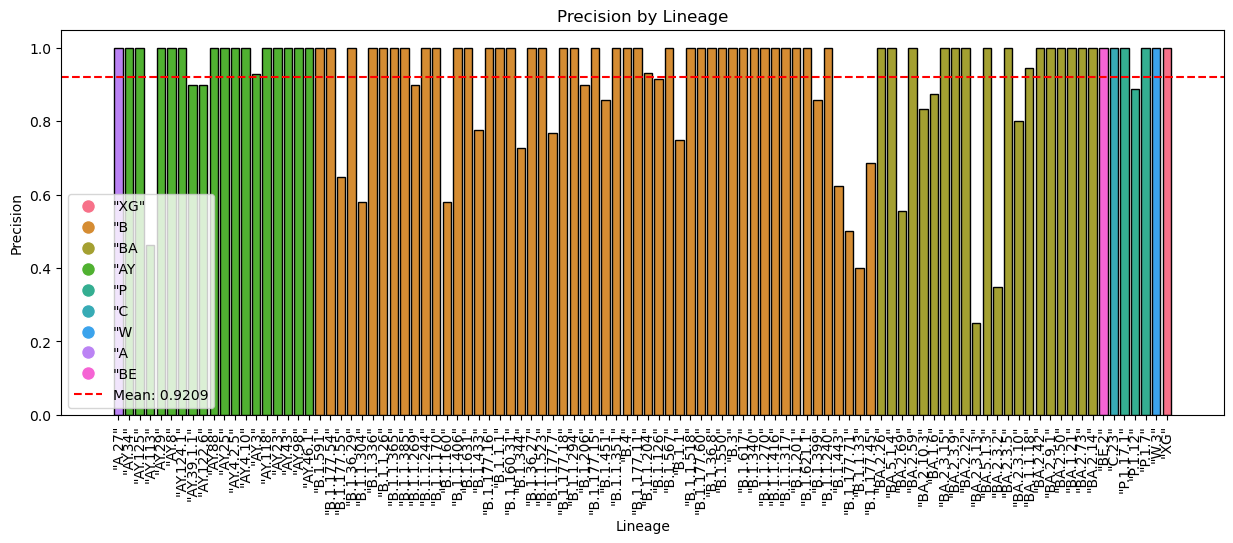

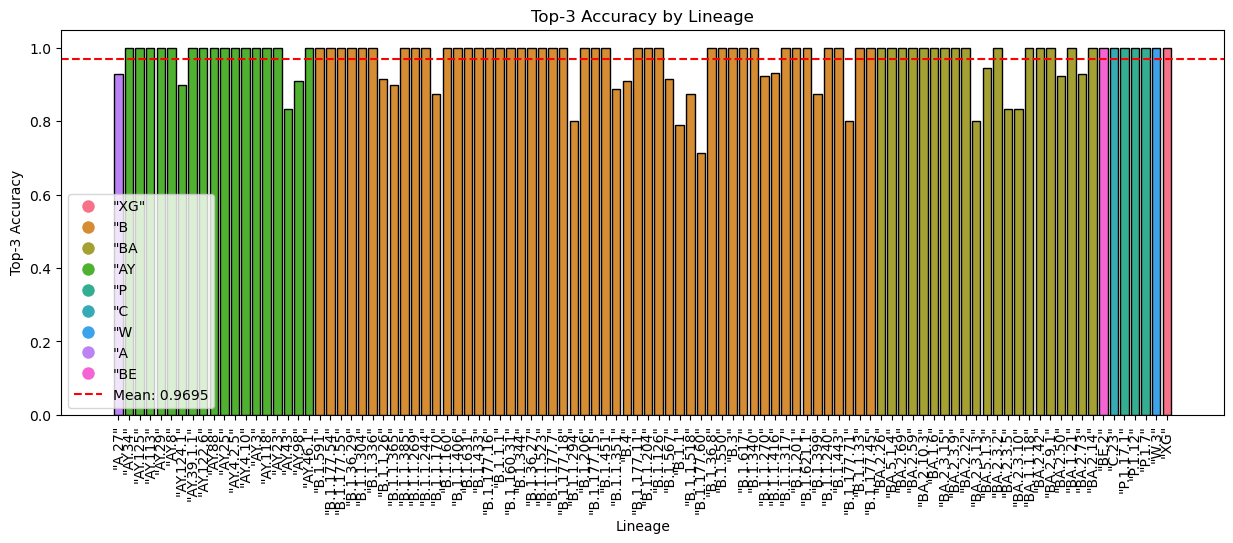

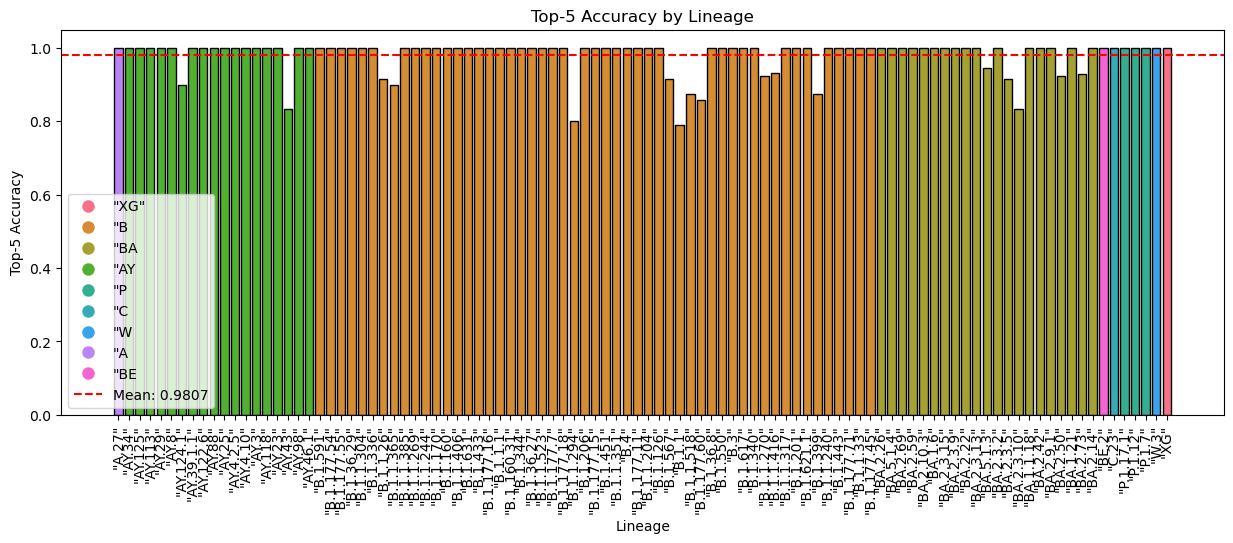

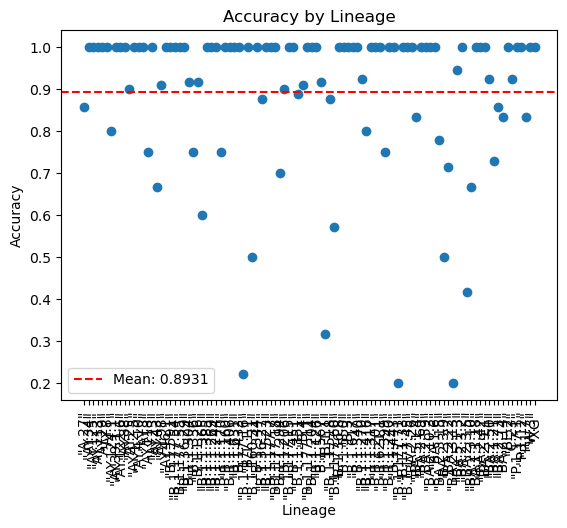

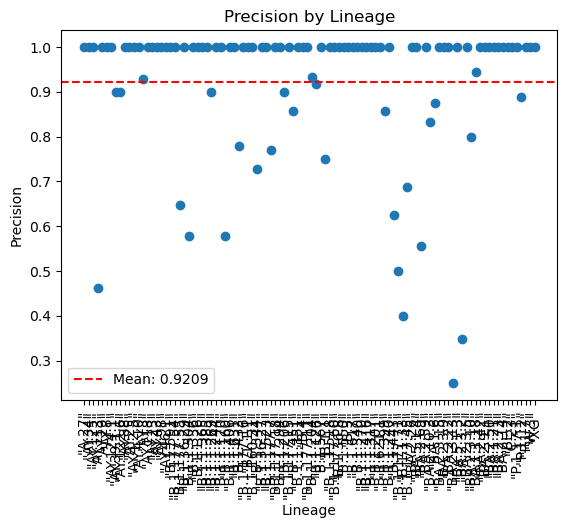

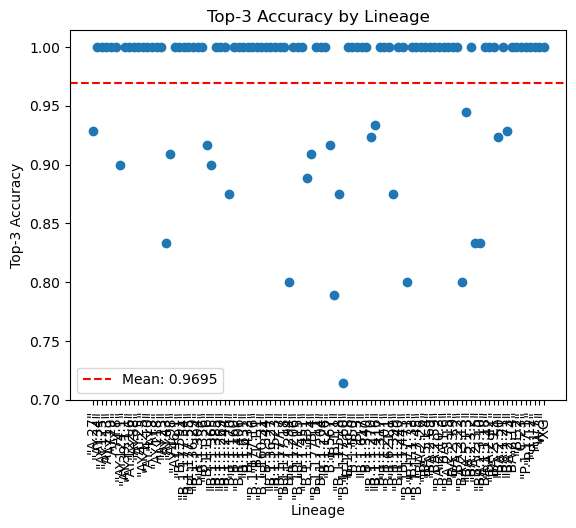

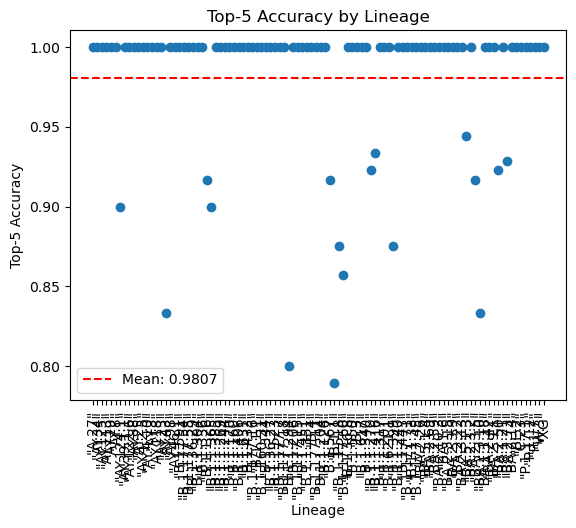

In [67]:
import matplotlib.pyplot as plt
import seaborn as sns
# Loading the CSV file
file_path = "results.csv"
results_df = pd.read_csv(file_path)

# Displaying the updated dataframe
import seaborn as sns


# Function to extract the first part of the lineage name
def extract_first_part(lineage):
    return lineage.split('.')[0]


# Applying the extracted first part to a new column
results_df['first_part'] = results_df['Lineage'].apply(extract_first_part)

# Getting unique first parts and mapping them to colors
unique_first_parts = results_df['first_part'].unique()
color_mapping = sns.color_palette("husl", len(unique_first_parts))
color_dict = {first_part: color for first_part, color in zip(unique_first_parts, color_mapping)}


# Function to get color based on first part
def get_color(lineage):
    return color_dict[lineage]


# Applying color based on the first part of the lineage
results_df['color'] = results_df['first_part'].apply(get_color)
results_df = results_df.sort_values(by='first_part')


# Function to plot updated bar chart
# Function to plot final bar chart with black outline and mean in legend
def plot_final_bar_chart(metric, ylabel, title):
    mean_value = results_df[metric].mean()
    plt.figure(figsize=(15, 5))
    bars = plt.bar(results_df['Lineage'], results_df[metric], color=results_df['color'], edgecolor='black')
    mean_line = plt.axhline(y=mean_value, color='r', linestyle='--', label=f'Mean: {mean_value:.4f}')
    plt.xlabel('Lineage')
    plt.ylabel(ylabel)
    plt.title(title)
    legend_handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color_dict[first_part], markersize=10, label=first_part) for first_part in unique_first_parts]
    legend_handles.append(mean_line)
    plt.legend(handles=legend_handles)
    plt.xticks(rotation=90)
    plt.show()


# Plotting updated bar charts


def plot_scatter_chart(metric, ylabel, title):
    mean_value = results_df[metric].mean()
    plt.scatter(results_df['Lineage'], results_df[metric])
    plt.axhline(y=mean_value, color='r', linestyle='--', label=f'Mean: {mean_value:.4f}')
    plt.xlabel('Lineage')
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend()
    plt.xticks(rotation=90)
    plt.show()


def extract_numeric(value):
    if isinstance(value, str) and value.startswith("tensor("):
        # Extract the numeric value from the tensor string
        start_idx = value.find("(") + 1
        end_idx = value.find(",")
        numeric_value = float(value[start_idx:end_idx])
        return numeric_value
    else:
        return value

# Applying the modified extract_numeric function to the columns
results_df['accuracy'] = results_df['accuracy'].apply(extract_numeric)
results_df['precision'] = results_df['precision'].apply(extract_numeric)
results_df['top3acc'] = results_df['top3acc'].apply(extract_numeric)
results_df['top5acc'] = results_df['top5acc'].apply(extract_numeric)

# Now you can proceed with your plotting functions without encountering a TypeError
plot_final_bar_chart('accuracy', 'Accuracy', 'Accuracy by Lineage')
plot_final_bar_chart('precision', 'Precision', 'Precision by Lineage')
plot_final_bar_chart('top3acc', 'Top-3 Accuracy', 'Top-3 Accuracy by Lineage')
plot_final_bar_chart('top5acc', 'Top-5 Accuracy', 'Top-5 Accuracy by Lineage')

# Plotting scatter plots for accuracy, precision, top-3 accuracy, and top-5 accuracy
plot_scatter_chart('accuracy', 'Accuracy', 'Accuracy by Lineage')
plot_scatter_chart('precision', 'Precision', 'Precision by Lineage')
plot_scatter_chart('top3acc', 'Top-3 Accuracy', 'Top-3 Accuracy by Lineage')
plot_scatter_chart('top5acc', 'Top-5 Accuracy', 'Top-5 Accuracy by Lineage')